<a href="https://colab.research.google.com/github/YardenGoraly/Mujoco_fun/blob/main/MuJoCo_fun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco as mj
  mj.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


In [2]:
!pip install robot_descriptions
!pip install dm_control

from robot_descriptions import panda_mj_description


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 70.1 MB/s eta 0:00:00
Cloning https://github.com/deepmind/mujoco_menagerie.git...


100%|██████████| 1483.0/1483.0 [00:24<00:00, 59.54it/s]


In [3]:
from robot_descriptions.loaders.mujoco import load_robot_description
from dm_control import mjcf
import PIL.Image

ball_xml = """
<mujoco model="ball">
    <worldbody>
        <body name="ball" pos="0.2 0.0 0.1">
            <geom type="sphere" size="0.05" rgba="1 0 0 1"/>
        </body>
    </worldbody>
</mujoco>
"""

hand_path = "/content/mujoco_menagerie/wonik_allegro/right_hand.xml"

hand_model = mjcf.from_path(hand_path)
ball_model = mjcf.from_xml_string(ball_xml)

arena = mjcf.RootElement()
chequered = arena.asset.add('texture', type='2d', builtin='checker', width=300,
                            height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = arena.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[5, 5], reflectance=.2)
arena.worldbody.add('geom', type='plane', size=[2, 2, .1], material=grid)
for x in [-2, 2]:
  arena.worldbody.add('light', pos=[x, -1, 3], dir=[-x, 1, -2])
arena.attach(hand_model)

# Load model.
# model = load_robot_description("allegro_hand_mj_description")
# model = mj.MjModel.from_xml_string(hand_and_ball_xml)
# model = mj.MjModel.from_xml_path(hand_path)
# data = mj.MjData(arena)
physics = mjcf.Physics.from_mjcf_model(arena)

# print("here", box)

# Make sure offscreen rendering can support the desired resolution.
# arena.vis.global_.offheight = 480
# arena.vis.global_.offwidth = 640

# renderer = mj.Renderer(arena, height=480, width=640)
PIL.Image.fromarray(physics.render())

FileNotFoundError: [Errno 2] No such file or directory: '/content/mujoco_menagerie/wonik_allegro/right_hand.xml'

""

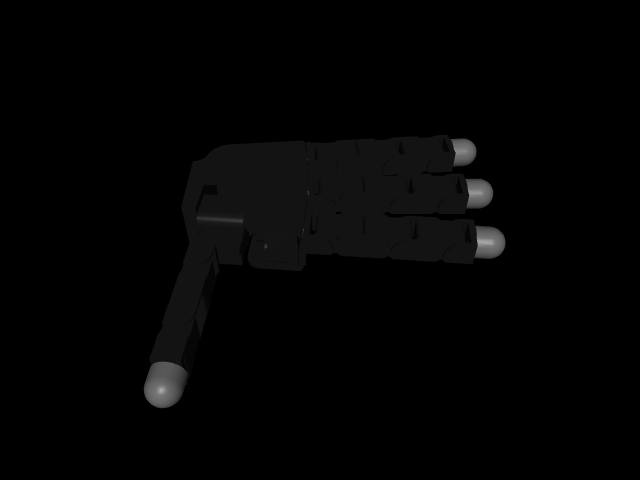

In [ ]:
mj.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

""

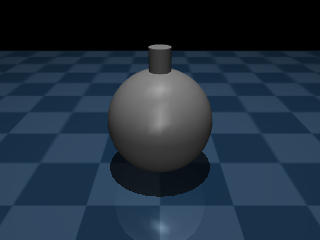

In [ ]:
# environment = """
# <mujoco model="environment>
#   <worldbody>
#     <light pose="0 0 0.6"/>
#   </worldbody>
# </mujoco>
# """
tippe_top = """
<mujoco model="tippe top">
  <option integrator="RK4"/>

  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>

  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="0 0 .02">
      <freejoint/>
      <geom name="ball" type="sphere" size=".02" />
      <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
      <geom name="ballast" type="box" size=".023 .023 0.005"  pos="0 0 -.015"
       contype="0" conaffinity="0" group="3"/>
    </body>
  </worldbody>

  <keyframe>
    <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200" />
  </keyframe>
</mujoco>
"""
model = mj.MjModel.from_xml_string(tippe_top)
data = mj.MjData(model)
mj.mj_forward(model, data)
with mj.Renderer(model) as renderer:
  renderer.update_scene(data, camera="closeup")
  media.show_image(renderer.render())